In [1]:
import torch 
import torch.nn as nn 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

In [5]:
df=pd.read_csv('D:\\Downloads\\PYTORCH_NOTEBOOKS\\PYTORCH_NOTEBOOKS\\Data\\TimeSeriesData\\Energy_production.csv',parse_dates=True,index_col=0)
df.dropna(inplace=True)
len(df)

325

In [7]:
df.columns

Index(['IPG2211A2N'], dtype='object')

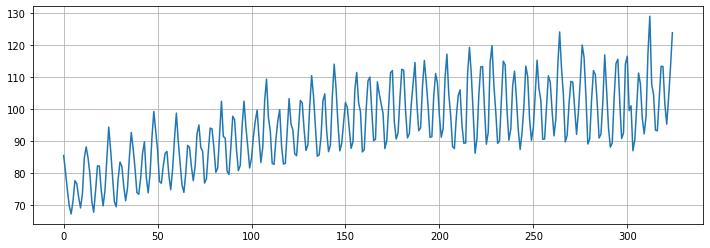

In [11]:
energy_prod_data=df['IPG2211A2N'].values.astype('float')
plt.figure(figsize=(12,4))
plt.plot(energy_prod_data)


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
test_size=24
train_dat=energy_prod_data[:-24]
test_dat=energy_prod_data[-24:]
train_dat_norm=scaler.fit_transform(train_dat.reshape(-1,1))
test_dat=scaler.transform(test_dat.reshape(-1,1))

In [40]:
def create_data_rec(seq,ws):
    dat_list=[]
    for i in range(len(seq)-ws):
        dat_in=seq[i:i+ws]
        dat_target=seq[i+ws:i+ws+1]
        dat_list.append((dat_in,dat_target))
    return(dat_list)
ws=12
train_dat_list=create_data_rec(torch.FloatTensor(train_dat_norm),ws)

In [48]:
class lstm_mod(nn.Module):
    def __init__(self,in_size=1,out_size=1,hid_size=50):
        super(lstm_mod,self).__init__()
        self.hidden_size=hid_size
        self.lstm=nn.LSTM(in_size,hid_size)
        self.lin=nn.Linear(hid_size,out_size)
        self.relu=nn.ReLU()
        self.hidden=(torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))
    def forward(self,X):
        lstm_out,hid_out=self.lstm(X.view(len(X),1,-1),self.hidden)
        self.hidden=hid_out
        pred=self.relu(self.lin(lstm_out))
        return(pred[-1])
torch.manual_seed(101)
model=lstm_mod()
crit=nn.MSELoss()
opt=torch.optim.Adam(model.parameters())
model

lstm_mod(
  (lstm): LSTM(1, 50)
  (lin): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
def train_single_epoch(data,mod,crit,opt,disp_int):
    batch_loss_tracker=[]
    for b,ex in enumerate(data):
        opt.zero_grad()
        mod.hidden=(torch.zeros(1,1,mod.hidden_size),torch.zeros(1,1,mod.hidden_size))
        pred=mod.forward(ex[0])
        loss=crit(pred,ex[1])
        batch_loss_tracker.append(loss.item())
        loss.backward()
        opt.step()
        if(b%disp_int==0):
            print(f'Batch:{b} Loss:{batch_loss_tracker[b]:0.4f}')
    return(mod,batch_loss_tracker)
def train_model(data,mod,crit,opt,disp_int=20,num_epochs=10):
    epoch_loss_tracker=[]
    for i in range(num_epochs):
        print(f'________________Epoch:{i}_______________')
        mod,batch_loss_tracker=train_single_epoch(data,mod,crit,opt,disp_int)
        epoch_loss_tracker.extend(batch_loss_tracker)
    return(mod,epoch_loss_tracker)
mod,epoch_loss_tracker=train_model(train_dat_list,model,crit,opt,disp_int=20,num_epochs=20)

________________Epoch:0_______________
Batch:0 Loss:0.1023
Batch:20 Loss:0.0039
Batch:40 Loss:0.0160
Batch:60 Loss:0.0388
Batch:80 Loss:0.0024
Batch:100 Loss:0.0414
Batch:120 Loss:0.0948
Batch:140 Loss:0.0035
Batch:160 Loss:0.0299
Batch:180 Loss:0.0514
Batch:200 Loss:0.0050
Batch:220 Loss:0.0656
Batch:240 Loss:0.0856
Batch:260 Loss:0.0091
Batch:280 Loss:0.0314
________________Epoch:1_______________
Batch:0 Loss:0.0452
Batch:20 Loss:0.0083
Batch:40 Loss:0.0010
Batch:60 Loss:0.0387
Batch:80 Loss:0.0007
Batch:100 Loss:0.0292
Batch:120 Loss:0.0803
Batch:140 Loss:0.0055
Batch:160 Loss:0.0159
Batch:180 Loss:0.0035
Batch:200 Loss:0.0000
Batch:220 Loss:0.0305
Batch:240 Loss:0.0114
Batch:260 Loss:0.0001
Batch:280 Loss:0.0031
________________Epoch:2_______________
Batch:0 Loss:0.0552
Batch:20 Loss:0.0046
Batch:40 Loss:0.0005
Batch:60 Loss:0.0072
Batch:80 Loss:0.0008
Batch:100 Loss:0.0119
Batch:120 Loss:0.0256
Batch:140 Loss:0.0000
Batch:160 Loss:0.0025
Batch:180 Loss:0.0013
Batch:200 Loss:0.0000

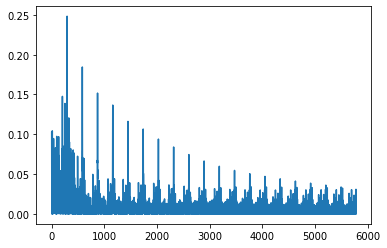

In [50]:
plt.plot(epoch_loss_tracker)

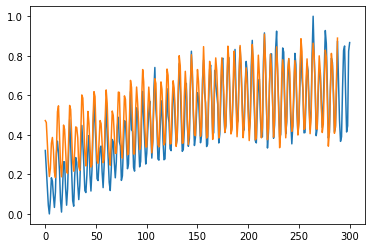

In [54]:
preds_train=[]
for i in range(len(train_dat_list)):
    model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
    preds=model.forward(train_dat_list[i][0])
    preds_train.append(preds.detach().numpy())
plt.plot(train_dat_norm)
plt.plot(np.squeeze(preds_train))